#  Прогнозирование заказов такси

Такси-компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Для этого нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer

## Подготовка

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [3]:
def about_df(list_df):
    '''выводит информацию о всех датасетах из списка list_df'''
    for c, i in enumerate(list_df):
        print("**** DATASET_"+str(c+1)+' ****')
        display(i.info())
        display(i.describe().round(2))
        print(f'Количество дубликатов: {i.duplicated().sum()}')
        print('Количество пропущенных значений:', i.isnull().sum(), sep='\n')
        print()

In [4]:
about_df([data])

**** DATASET_1 ****
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,num_orders
count,4416.00
mean,84.42
std,45.02
min,0.00
25%,54.00
50%,78.00
75%,107.00
max,462.00


Количество дубликатов: 4165
Количество пропущенных значений:
num_orders    0
dtype: int64



**Вывод**
<br>Данные, разбитые на часовые промежутки содержат информацию с 1 марта по 31 августа 2018 года. Имеются аномально высокое значение - 462 заказа за час. Пропуски отсутствуют.

## Анализ данных

In [5]:
temp = data.copy()

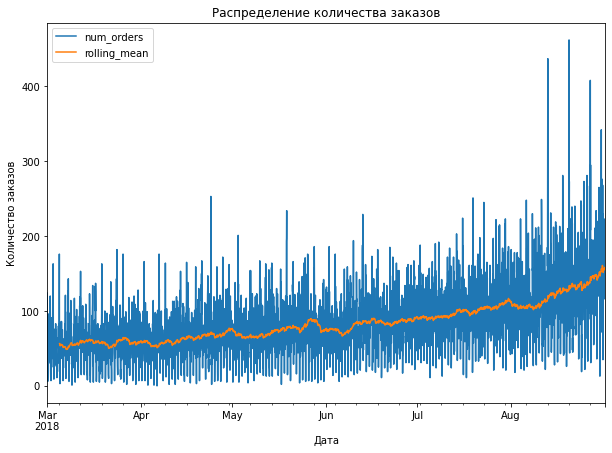

In [6]:
# посмотрим на распределение заказов за указанный период
temp['rolling_mean'] = data.rolling(100).mean()
temp.plot(
    title='Распределение количества заказов',
    xlabel='Дата',
    ylabel='Количество заказов',
    figsize=(10, 7));

Видно, что в августе тренд на увеличение заказов немного усиливается по сравнению с другими месяцами.

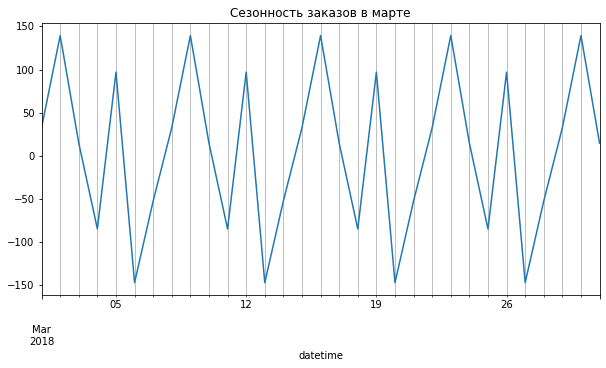

In [7]:
# посмотрим на количество заказов по дням недели в первый месяц заказов
temp = data['2018-03':'2018-04'].resample('1D').sum()

decomposed = seasonal_decompose(temp['num_orders'])

ax = plt.gca()
ax.grid(True, which='both')

decomposed.seasonal['2018-03-01':'2018-03-31'].plot(figsize=(10, 5),
                                                    title='Сезонность заказов в марте',
                                                    ax=ax);

Видно, что по вторникам и воскресеньям такси заказывают реже, а по пятницам и понедельникам чаще.

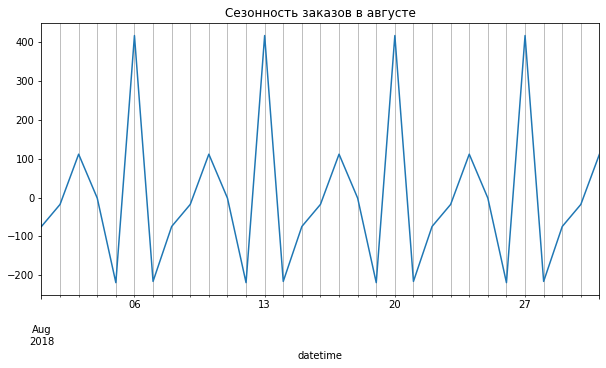

In [8]:
# посмотрим на количество заказов по дням недели в последний месяц заказов
temp = data['2018-08':'2018-08'].resample('1D').sum()

decomposed = seasonal_decompose(temp['num_orders'])

ax = plt.gca()
ax.grid(True, which='both')

decomposed.seasonal['2018-08-01':'2018-08-31'].plot(figsize=(10, 5), 
                                                    title='Сезонность заказов в августе',
                                                    ax=ax);

В отличии от марта, в августе уменьшились случаи заказа такси по пятницам. В воскресенье и вторник такси также заказывают реже всего

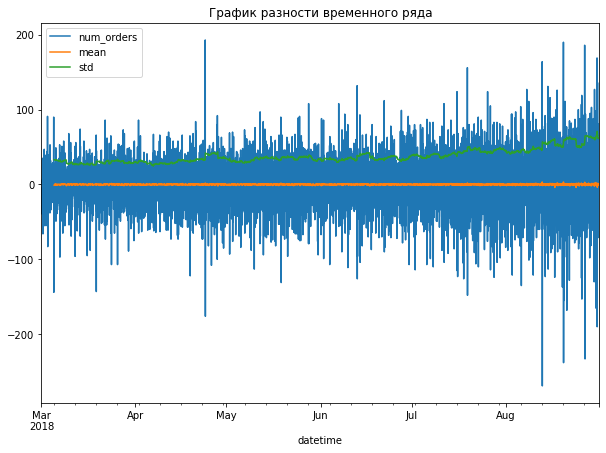

In [9]:
temp = data - data.shift()
temp['mean'] = temp['num_orders'].rolling(100).mean()
temp['std'] = temp['num_orders'].rolling(100).std()

temp.plot(figsize=(10, 7),
         title='График разности временного ряда');

График разности временного ряда также говорит о наличии линейности в данных и о наличии больших отклонений по заказам в сутки в августе.

**Вывод**
<br> В августе тренд на увеличение заказов немного усиливается по сравнению с другими месяцами. По вторникам и воскресеньям в марте такси заказывали реже, а по пятницам и понедельникам чаще.В отличии от марта, в августе уменьшились случаи заказа такси по пятницам. В воскресенье и вторник такси также заказывают реже всего.График разности временного ряда также говорит о наличии линейности в данных и о наличии больших отклонений по заказам в сутки в августе.

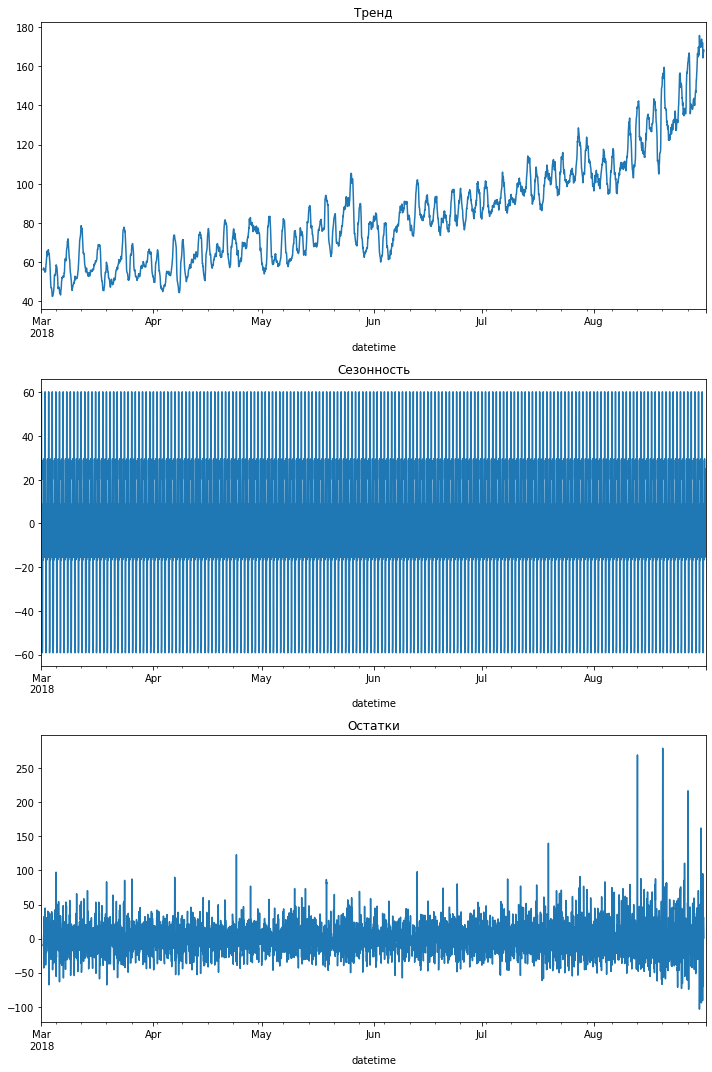

In [10]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(10, 15))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

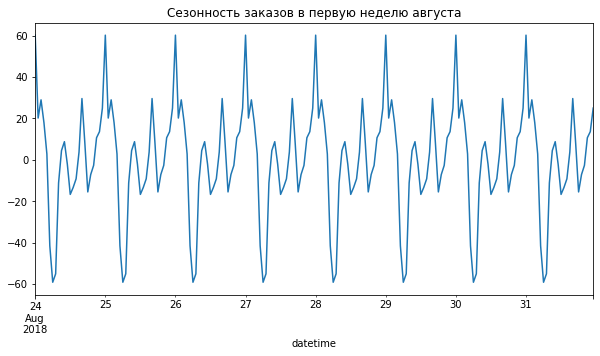

In [11]:
decomposed.seasonal['2018-08-24':'2018-08-31'].plot(figsize=(10, 5), 
                                                    title='Сезонность заказов в первую неделю августа');

## Подготовка данных

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    
    '''Функция для создания датафрейма с добавлением новых признаков'''
    
    global data_feat
    data_feat = data.copy()
    
    data_feat['month'] = data_feat.index.month
    data_feat['day'] = data_feat.index.day
    data_feat['dayofweek'] = data_feat.index.dayofweek

    for lag in range(1, max_lag + 1):
        data_feat['lag_{}'.format(lag)] = data_feat['num_orders'].shift(lag)

    data_feat['rolling_mean'] = data_feat['num_orders'].shift().rolling(rolling_mean_size).mean()

In [13]:
make_features(data, 30, 100) # примем максимальный сдвиг на 30 дней

In [14]:
data_feat.head(2)

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# деление на выборки
data_feat = data_feat.dropna()
X_train, X_test, y_train, y_test = train_test_split(data_feat.drop('num_orders', axis=1),
                                                    data_feat['num_orders'], 
                                                    test_size=0.1, 
                                                    shuffle=False)


print('train size:', X_train.shape, ' test size:', X_test.shape)

train size: (3884, 34)  test size: (432, 34)


In [16]:
# масштабирование данных (категориальных колонок нет)
num_columns = X_train.columns.to_list()
data_prep = ColumnTransformer([('num', StandardScaler(), num_columns)], remainder='passthrough')

X_train_prep = pd.DataFrame(data=data_prep.fit_transform(X_train),
                            columns=num_columns)
X_test_prep = pd.DataFrame(data=data_prep.transform(X_test),
                           columns=num_columns)

**Вывод**
<br>Данные разделены на выборки и масштабированы.

## Обучение моделей

Поскольку привычная кросс-валидация не подходит для временных рядов, будем использовать TimeSeriesSplit. 
<br>Это специализированный метод перекрёстной проверки для данных временных рядов в библиотеке scikit-learn. Он сохраняет временной порядок наблюдений, гарантируя, что модель оценивается на основе прошлых данных и тестируется на будущих данных, имитируя реальные сценарии. 

In [17]:
def get_rmse(y, pred):
    
    '''Функция для расчета RMSE'''
    
    return (mean_squared_error(y, pred))**0.5

# создадим метрику RMSE для кросс-валидации
RMSE = make_scorer(get_rmse, greater_is_better=False)

**Линейная регрессия:**

In [18]:
time_cv = TimeSeriesSplit(n_splits=5).split(X_train_prep)

linear_model = LinearRegression()
linear_model.fit(X_train_prep, y_train)

LinearRegression()

In [19]:
%%time

model_score = cross_val_score(
    linear_model,
    X_train_prep,
    y_train,
    cv=time_cv,
    scoring=RMSE)

print('RMSE линейной регрессии:', -model_score.mean())
print()

RMSE линейной регрессии: 26.84225581385784

CPU times: user 441 ms, sys: 439 ms, total: 880 ms
Wall time: 901 ms


**LGBMRegressor:**

In [20]:
time_cv = TimeSeriesSplit(n_splits=5).split(X_train_prep)

model_lgbm = LGBMRegressor()
model_lgbm.fit(X_train_prep, y_train)

LGBMRegressor()

In [21]:
# Список параметров модели для сравнения
params = {
    'n_estimators': [1000, 1500],
    'max_depth': [1, 10, 15]
}

In [22]:
best_model = GridSearchCV(
    model_lgbm, 
    params, 
    cv=time_cv,
    scoring=RMSE,
    n_jobs=-1)

In [23]:
%%time

best_model.fit(X_train_prep, y_train)
print()


CPU times: user 4min 30s, sys: 2.97 s, total: 4min 33s
Wall time: 4min 37s


In [24]:
best_model.best_params_

{'max_depth': 10, 'n_estimators': 1000}

In [25]:
print('RMSE лучшей модели на тренировочной выборке:', -best_model.best_score_)

RMSE лучшей модели на тренировочной выборке: 25.83030675642906


**Вывод**
<br> Из моделирования видно, что модель LGBMRegressor с параметрами: 'max_depth': 10, 'n_estimators': 1000 лучше прогнозирует данный ряд, чем линейная регрессия. Но данная модель оказалась значительно медленнее: примерно 45 секунд на 1 комбинацию гиперпараметров против 1 секунды для линейной регрессии.

## Тестирование

In [26]:
# создадим датафрейм для сравнения предсказаний моделей
all_preds = pd.DataFrame()
all_preds['y_test'] = y_test

In [27]:
def get_pred(model, name):
    
    '''Расчет RMSE и отрисовка графика таргета и предикта'''
    
    pred_test = model.predict(X_test_prep)
    all_preds[name] = pred_test
    model_rmse = get_rmse(y_test, pred_test)
    print('RMSE модели:', round(model_rmse, 3))
    
    # график
    model_data = pd.DataFrame({'target':y_test, 
                               'prediction':pred_test})
    
    model_data.plot(figsize=(12, 7), 
                    title='Сравнение таргета и предикта для {}'.format(name),
                    xlabel='Дата',
                    ylabel='Количество заказов')

RMSE модели: 46.286


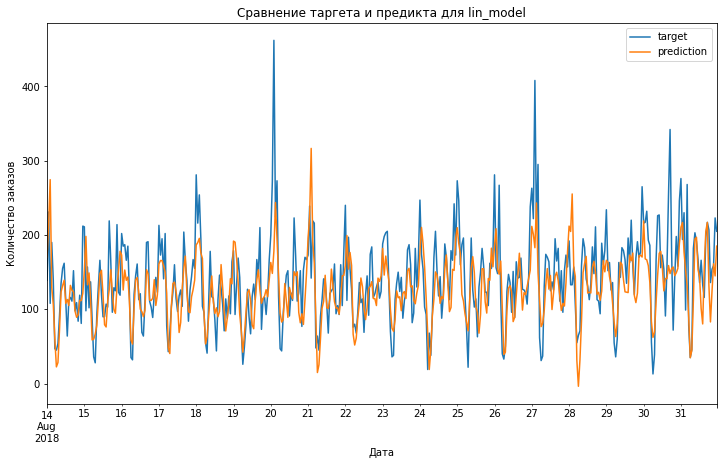

In [28]:
get_pred(linear_model, 'lin_model')

RMSE модели: 41.857


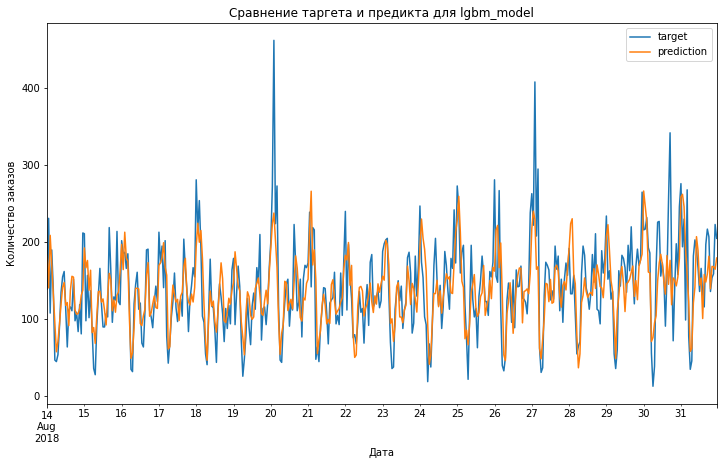

In [29]:
get_pred(best_model, 'lgbm_model')

Проверим, какая из моделей оказалась ближе к истине по отношению к каждому значению:

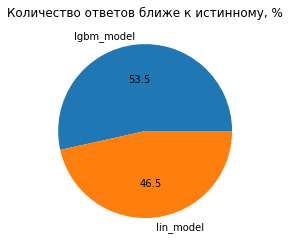

In [30]:
# колонка с указанием модели, которая оказалась ближе всех к истине
all_preds['closer'] = np.where(
    abs(all_preds['lin_model'] - all_preds['y_test']) < abs(all_preds['lgbm_model'] - all_preds['y_test']), 
    'lin_model', 'lgbm_model')

# диаграмма
temp = all_preds.pivot_table(index='closer', values='lin_model', aggfunc='count')
plt.pie(temp['lin_model'], autopct='%.1f', labels=temp.index)
plt.title('Количество ответов ближе к истинному, %');

Посмотрим на важность признаков в модели LGBM:

In [31]:
def feature_importanses(model):

    '''Функция для вывода 5 самых важных признаков модели'''
    
    features = {'feature': X_train_prep.columns, 'weight': model.feature_importances_}
    return pd.DataFrame(features).sort_values(by='weight', ascending=False).head(5)

In [32]:
model_lgbm = LGBMRegressor(n_estimators=1000, max_depth=10)
model_lgbm.fit(X_train_prep, y_train)

LGBMRegressor(max_depth=10, n_estimators=1000)

In [33]:
feature_importanses(model_lgbm)

,feature,weight
3,lag_1,1404
33,rolling_mean,1232
5,lag_3,1058
26,lag_24,997
4,lag_2,943


**Вывод**
<br>На тестовых данных данная модель показала значение метрики RMSE: 41.857, что ниже целевых 48. Стоит отметить, что линейная модель с метрикой 46.286 также уложилась в граничное значение. Проверка на количество более близких к истине значений показала, что LGBM оказывается ближе к истине в 53.5% случаев. Для данной модели наиболее важными признаками оказались: сдвиг на 1, 3, 24, 2 дня и скользящее среднее с окном = 100.

## Вывод

Данные, разбитые на часовые промежутки содержат информацию с 1 марта по 31 августа 2018 года. Имеются аномально высокое значение - 462 заказа за час. Пропуски отсутствуют.


В августе тренд на увеличение заказов немного усиливается по сравнению с другими месяцами. По вторникам и воскресеньям в марте такси заказывали реже, а по пятницам и понедельникам чаще.В отличии от марта, в августе уменьшились случаи заказа такси по пятницам. В воскресенье и вторник такси также заказывают реже всего.График разности временного ряда также говорит о наличии линейности в данных и о наличии больших отклонений по заказам в сутки в августе.


Поскольку привычная кросс-валидация не подходит для временных рядов, использовался TimeSeriesSplit. Это специализированный метод перекрёстной проверки для данных временных рядов в библиотеке scikit-learn. Он сохраняет временной порядок наблюдений, гарантируя, что модель оценивается на основе прошлых данных и тестируется на будущих данных, имитируя реальные сценарии.


Оказалось, что модель LGBMRegressor с параметрами: 'max_depth': 10, 'n_estimators': 1000 лучше прогнозирует данный ряд, чем обычная линейная регрессия. Но данная модель оказалась значительно медленнее: примерно 45 секунд на 1 комбинацию гиперпараметров против 1 секунды для линейной регрессии.
<br>На тестовых данных данная модель показала значение метрики RMSE: 41.857, что ниже целевых 48. Стоит отметить, что линейная модель с метрикой 46.286 также уложилась в граничное значение. Проверка на количество более близких к истине значений показала, что LGBM оказывается ближе к истине в 53.5% случаев. Для данной модели наиболее важными признаками оказались: сдвиг на 1, 3, 24, 2 дня и скользящее среднее с окном = 100.